# Load libraries

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import re
from fbprophet import Prophet

Question I would like to clarify through this data set and data analysis:
1. What are the top 5 crime categories in Chicago?
2. What are the city areas where this category is the largest?
3. For the largest crime category in Chicago, what are the largest sub-categories?
4. Can we provide a daily forecast for the largest crime category one year ahead with acceptable level of accuracy?

# Read multiple csv files into single data frame

In [6]:
# please make sure you download the dataset and save it in /data folder
# the dataset can be downloaded here: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
df = pd.read_csv(r'data/crime.csv') 

b'Skipping line 1513591: expected 23 fields, saw 24\n'
C:\Users\shukhrat.khodjaev\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning:

Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\shukhrat.khodjaev\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


# Data Overview

ID - Unique identifier for the record.

Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.

Date - Date when the incident occurred. this is sometimes a best estimate.

Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.

IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.

Primary Type - The primary description of the IUCR code.

Description - The secondary description of the IUCR code, a subcategory of the primary description.

Location Description - Description of the location where the incident occurred.

Arrest - Indicates whether an arrest was made.

Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.

Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.

District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.

Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.

Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.

FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.

X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

Year - Year the incident occurred.

Updated On - Date and time the record was last updated.

Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

In [445]:
df.shape

(7929925, 22)

In [7]:
df.head().T

,0,1,2,3,4
ID,4786321,4676906,4789749,4789765,4677901
Case Number,HM399414,HM278933,HM402220,HM402058,HM275615
Date,01/01/2004 12:01:00 AM,03/01/2003 12:00:00 AM,06/20/2004 11:00:00 AM,12/30/2004 08:00:00 PM,05/01/2003 01:00:00 AM
Block,082XX S COLES AVE,004XX W 42ND PL,025XX N KIMBALL AVE,045XX W MONTANA ST,111XX S NORMAL AVE
IUCR,0840,2825,1752,0840,0841
Primary Type,THEFT,OTHER OFFENSE,OFFENSE INVOLVING CHILDREN,THEFT,THEFT
Description,FINANCIAL ID THEFT: OVER $300,HARASSMENT BY TELEPHONE,AGG CRIM SEX ABUSE FAM MEMBER,FINANCIAL ID THEFT: OVER $300,FINANCIAL ID THEFT:$300 &UNDER
Location Description,RESIDENCE,RESIDENCE,RESIDENCE,OTHER,RESIDENCE
Arrest,False,False,False,False,False
Domestic,False,True,False,False,False


In [8]:
df.shape

(7941282, 22)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7941282 entries, 0 to 7941281
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            object
Year                    float64
Updated On              object
Latitude                object
Longitude               float64
Location                object
dtypes: bool(2), float64(6), int64(2), object(12)
memory usage: 1.2+ GB


In [10]:
df.isnull().mean()

ID                      0.000000e+00
Case Number             8.814698e-07
Date                    0.000000e+00
Block                   0.000000e+00
IUCR                    0.000000e+00
Primary Type            0.000000e+00
Description             0.000000e+00
Location Description    2.505893e-04
Arrest                  0.000000e+00
Domestic                0.000000e+00
Beat                    0.000000e+00
District                1.145911e-05
Ward                    8.817518e-02
Community Area          8.841028e-02
FBI Code                0.000000e+00
X Coordinate            1.329420e-02
Y Coordinate            1.329420e-02
Year                    0.000000e+00
Updated On              0.000000e+00
Latitude                1.329420e-02
Longitude               1.329433e-02
Location                1.329433e-02
dtype: float64

- Ward and Community area data miss in about 8.8% of the cases - this is quite a considerable ratio of missing data however not critical for our analysis and can be omitted, there is no need to drop data because of those missing values
- Coordinates and Lat, Long, Location are not important for us here therefore can be omited.


In [17]:
# Keep only the attributes that we want to use in this research

df = df[['Date','Block','Primary Type', 'Description',
        'Location Description', 'Arrest','Domestic',
        'Beat','District','Ward','Community Area', 'Latitude', 'Longitude']]

## Convert Date field into date format

In [548]:
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y %I:%M:%S %p') #08/17/2015 03:03:40 PM
df['date'] = df['Date'].dt.date
df['hour'] = df['Date'].dt.hour
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.week
df['weekday'] = df['Date'].dt.weekday
df['dayofyear'] = df['Date'].dt.dayofyear
df['year-month'] = df.year + df.month/100

df = df[df.year < 2017]

# High level overview of crime in Chicago?

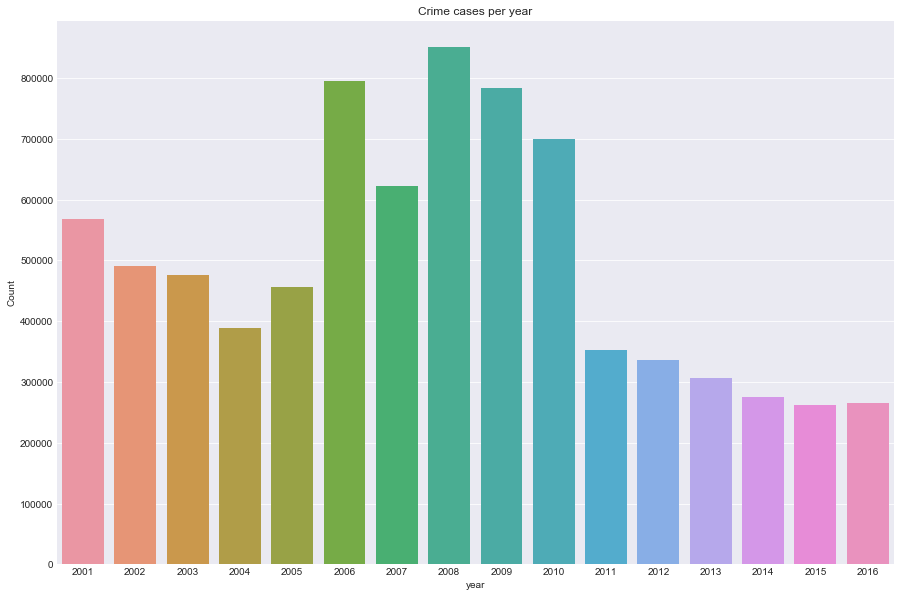

In [447]:
crime_year = df.groupby('year')['Date'].count().reset_index().rename(columns = {'Date':'Count'}).\
sort_values('Count', ascending = False)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (15,10))
sns.barplot(data = crime_year, x = 'year', y ='Count')
plt.title('Crime cases per year')
plt.show()

# Question 1: What are the top 5 largest crime categories in Chicago

In [21]:
print(f'Total number of various crime types in Chicago: {df["Primary Type"].nunique()}')

Total number of various crime types in Chicago: 35


In [449]:
pt_df = df.groupby('Primary Type')['Date'].count().reset_index().rename(columns = {'Date':'Count'}).\
sort_values('Count', ascending = False)

pt_df['Share'] = [x/pt_df.Count.sum() for x in pt_df.Count]
pt_df.head()

,Primary Type,Count,Share
33,THEFT,1638013,0.206561
2,BATTERY,1440742,0.181684
6,CRIMINAL DAMAGE,921695,0.116230
18,NARCOTICS,885020,0.111605
25,OTHER OFFENSE,491048,0.061923


## Yearly overview

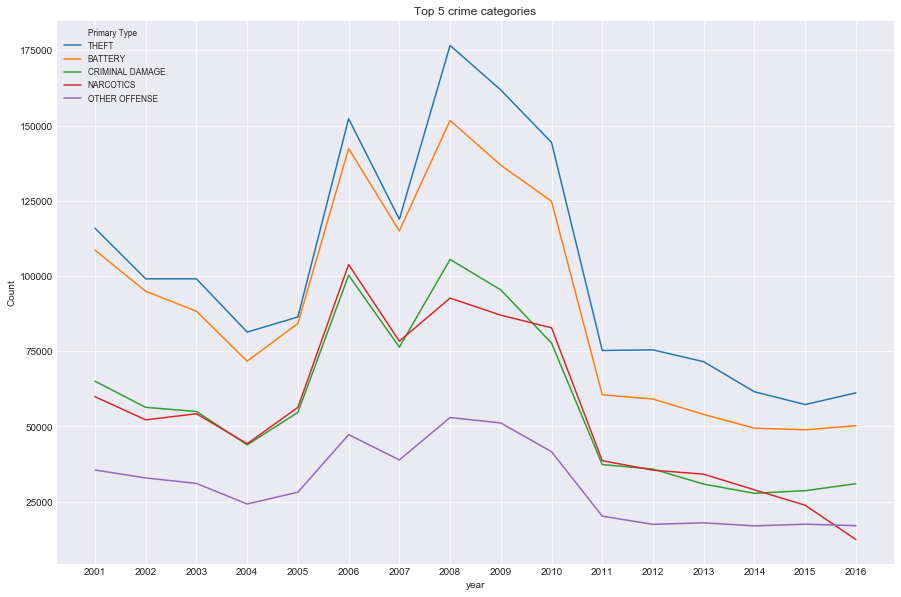

In [450]:
top5_cat_year = df[df['Primary Type'].isin(list(pt_df['Primary Type'].head()))].\
groupby(['Primary Type','year'])['Date'].count().reset_index().rename(columns = {'Date':'Count'}).\
sort_values('Count', ascending = False)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (15,10))
sns.lineplot(data = top5_cat_year, x = 'year', y ='Count', hue = 'Primary Type')
plt.title('Top 5 crime categories')
plt.legend(loc = 'upper left',fontsize = 'small')
plt.xticks(range(2001,2017,1))
plt.show()

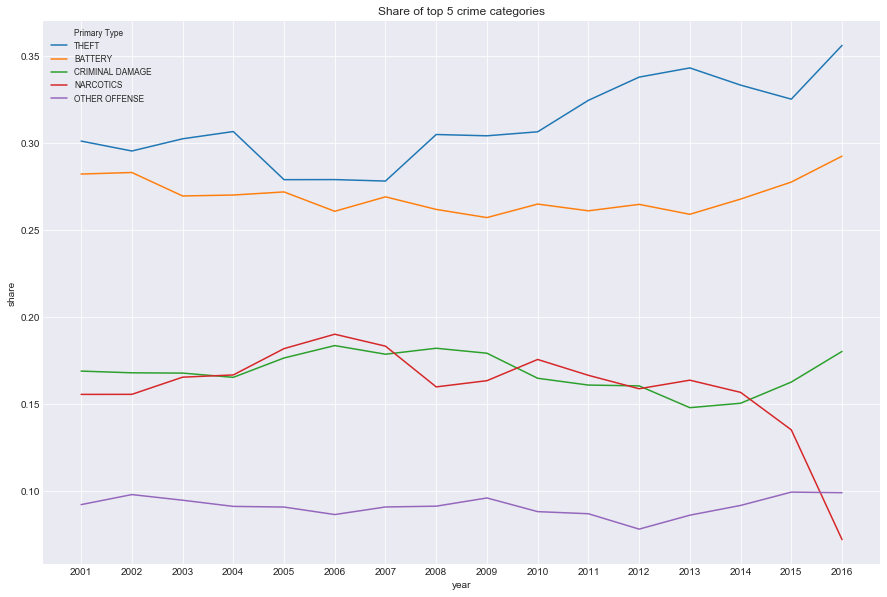

In [451]:
top5_cat_year['share'] = [x/top5_cat_year[top5_cat_year.year == y].Count.sum() for x,y in list(zip(top5_cat_year.Count, top5_cat_year.year))]

plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (15,10))
sns.lineplot(data = top5_cat_year, x = 'year', y ='share', hue = 'Primary Type')
plt.title('Share of top 5 crime categories')
plt.xticks(range(2001,2017,1))
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

## Monthly overview

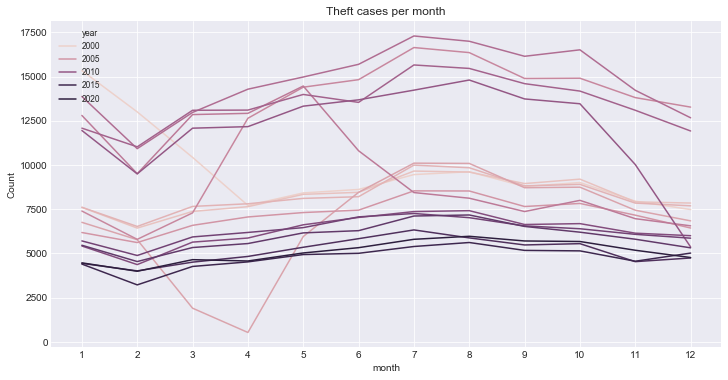

In [452]:
theft_ym = df[df['Primary Type'] == 'THEFT'].groupby(['Primary Type','year','month']).Date.count().\
            reset_index().rename(columns = {'Date':'Count'})
theft_ym['share'] = [x/theft_ym[theft_ym.year == y].Count.sum() for x,y in list(zip(theft_ym.Count, theft_ym.year))]

plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (12,6))
sns.lineplot(data = theft_ym, x = 'month', y ='Count', hue = 'year')
plt.title('Theft cases per month')
plt.xticks(range(1,13))
plt.legend(loc = 'upper left',fontsize = 'small')
plt.show()

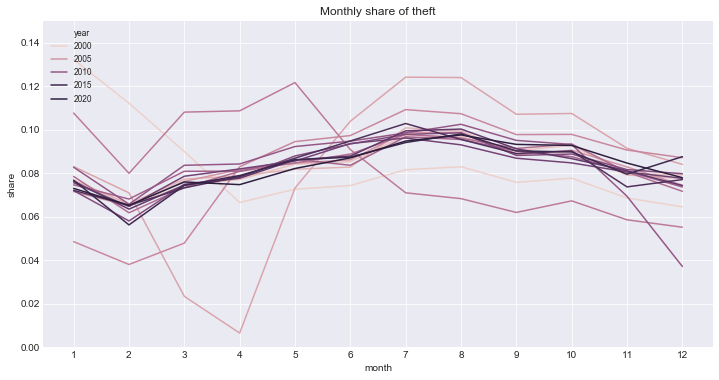

In [453]:
plt.figure(figsize = (12,6))
sns.lineplot(data = theft_ym, x = 'month', y ='share', hue = 'year')
plt.title('Monthly share of theft')
plt.legend(loc = 'upper left',fontsize = 'small')
plt.ylim([0,0.15])
plt.xticks(range(1,13))
plt.show()

## Weekly overview

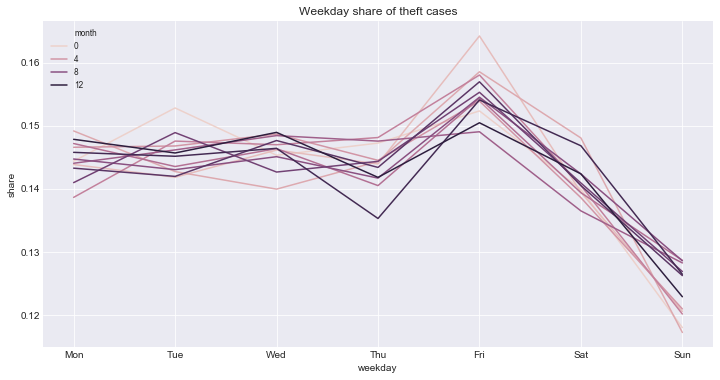

In [41]:
theft_wd = df[df['Primary Type'] == 'THEFT'].groupby(['Primary Type','year','month', 'weekday']).Date.count().\
            reset_index().rename(columns = {'Date':'Count'})
theft_wd['share'] = [x/theft_wd[theft_wd.year == y].Count.sum() for x,y in list(zip(theft_wd.Count, theft_wd.year))]

theft_mwd = theft_wd.groupby(['month','weekday']).Count.mean().reset_index()
theft_mwd['share'] = [x/theft_mwd[theft_mwd.month == y].Count.sum() for x,y in list(zip(theft_mwd.Count, theft_mwd.month))]

plt.figure(figsize = (12,6))
sns.lineplot(data = theft_mwd, x = 'weekday', y ='share', hue = 'month')
plt.title('Weekday share of theft cases')
plt.legend(loc = 'upper left',fontsize = 'small')
plt.xticks(range(0,7), ['Mon','Tue','Wed','Thu', 'Fri','Sat', 'Sun'])
plt.show()

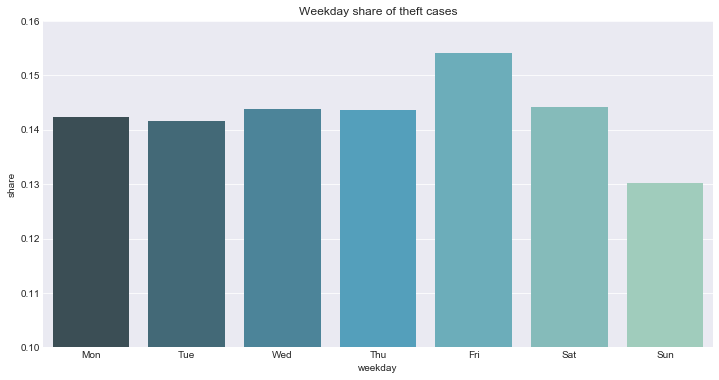

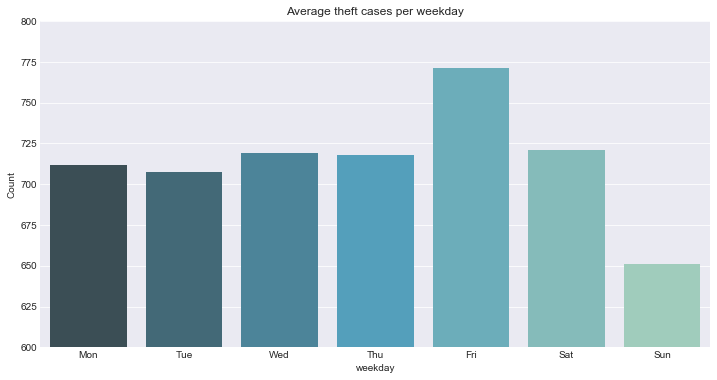

In [42]:
theft_awd = theft_wd[theft_wd.year > 2013].groupby('weekday').Count.mean().reset_index()
theft_awd['share'] = [x/theft_awd.Count.sum() for x in theft_awd.Count]

plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (12,6))
sns.barplot(data = theft_awd, x = 'weekday', y ='share', palette = "GnBu_d")
plt.title('Weekday share of theft cases')
plt.legend(loc = 'upper left',fontsize = 'small')
plt.ylim([0.1,0.16])
plt.xticks([0,1,2,3,4,5,6],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.figure(figsize = (12,6))
sns.barplot(data = theft_awd, x = 'weekday', y ='Count', palette = "GnBu_d")
plt.title('Average theft cases per weekday')
plt.legend(loc = 'upper left',fontsize = 'small')
plt.ylim([600,800])
plt.xticks([0,1,2,3,4,5,6],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.show()


## Hourly distribution

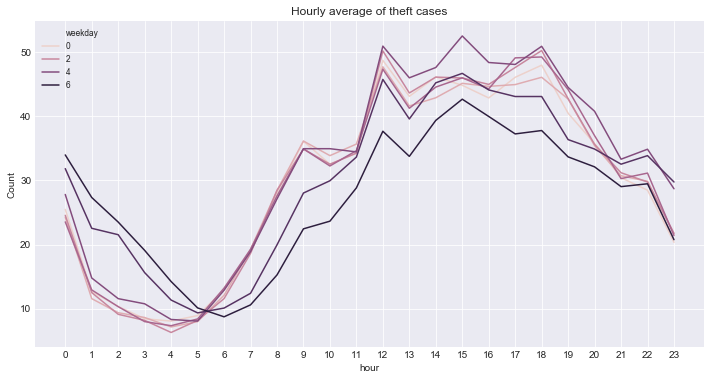

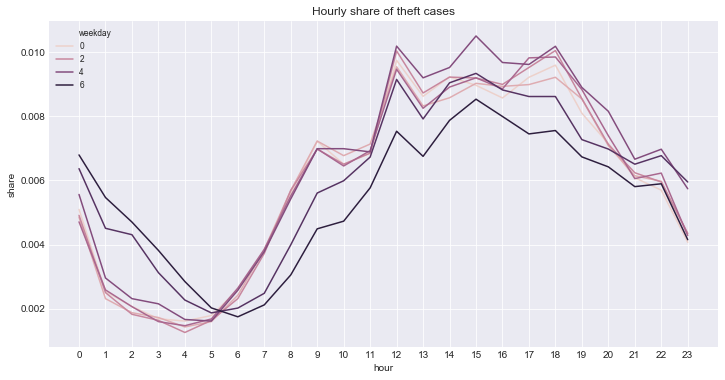

In [45]:
theft_hourly = df[(df['Primary Type'] == 'THEFT') & (df.year > 2013)].groupby(['year','month','hour','weekday'])['Date'].count()\
                .reset_index().rename(columns = {'Date':'Count'})

theft_hourly = theft_hourly.groupby(['weekday','hour']).Count.mean().reset_index()
theft_hourly['share'] = [x/theft_hourly.Count.sum() for x in theft_hourly.Count]

plt.figure(figsize = (12,6))
sns.lineplot(data = theft_hourly, x = 'hour', y ='Count', hue = 'weekday')
plt.title('Hourly average of theft cases')
plt.legend(loc = 'upper left',fontsize = 'small')
plt.xticks(np.arange(0,24,1))
plt.show()

plt.figure(figsize = (12,6))
sns.lineplot(data = theft_hourly, x = 'hour', y ='share', hue = 'weekday')
plt.title('Hourly share of theft cases')
plt.legend(loc = 'upper left',fontsize = 'small')
plt.xticks(np.arange(0,24,1))
plt.show()

# Question 2: What are the city areas where this category is the largest?

In [625]:
heatmap_df = df[(df['Primary Type'] == 'THEFT') & (df.year == 2016)].groupby(['Latitude','Longitude']).\
                Date.count().reset_index().rename(columns = {'Date':'Count'})

heatmap_df['Weight'] = [x / heatmap_df.Count.sum() for x in heatmap_df.Count]

In [626]:
m = folium.Map([41.8781, -87.6298], zoom_start=11, tiles = 'cartodbpositron')
longlat = heatmap_df[['Latitude', 'Longitude']].as_matrix()

m.add_children(plugins.HeatMap(longlat, radius=11))
m

C:\Users\shukhrat.khodjaev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\shukhrat.khodjaev\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  after removing the cwd from sys.path.


# Question 3: What are the largest sub-categories in the Theft category

In [46]:
sc_df = df[df['Primary Type'] == 'THEFT'].groupby('Description')['Date'].count().\
reset_index().rename(columns = {'Date':'Count'}).\
sort_values('Count', ascending = False)

sc_df

,Description,Count
1,$500 AND UNDER,610184
11,OVER $500,411908
8,FROM BUILDING,270033
14,RETAIL THEFT,188558
6,FINANCIAL ID THEFT: OVER $300,57810
12,POCKET-PICKING,36446
13,PURSE-SNATCHING,19838
7,FINANCIAL ID THEFT:$300 &UNDER,19590
4,ATTEMPT THEFT,13228
3,ATTEMPT FINANCIAL IDENTITY THEFT,4067


## Yearly overview

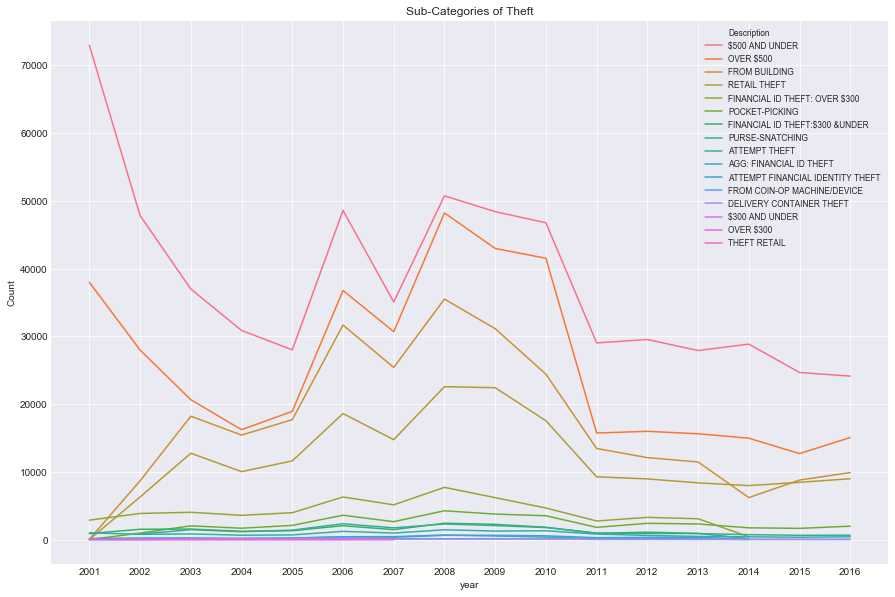

In [457]:
sc_year = df[(df['Primary Type'] == 'THEFT') & (df.Description.isin(list(sc_df['Description'])))].\
groupby(['Description','year'])['Date'].count().reset_index().rename(columns = {'Date':'Count'}).\
sort_values('Count', ascending = False)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (15,10))
sns.lineplot(data = sc_year, x = 'year', y ='Count', hue = 'Description')
plt.title('Sub-Categories of Theft')
plt.xticks(range(2001,2017,1))
plt.legend(loc = 'upper right', fontsize = 'small')
plt.show()

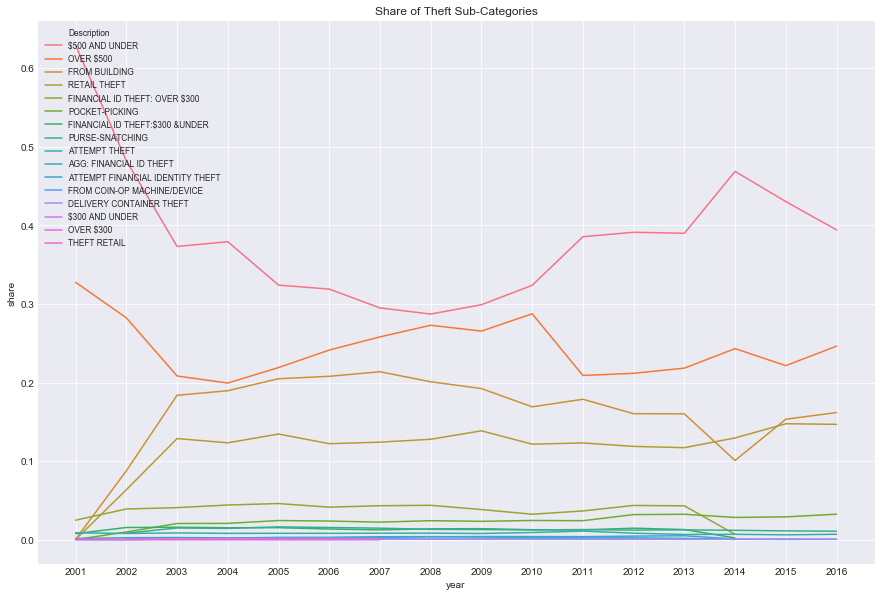

In [455]:
sc_year['share'] = [x/sc_year[sc_year.year == y].Count.sum() for x,y in list(zip(sc_year.Count, sc_year.year))]
plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (15,10))
sns.lineplot(data = sc_year, x = 'year', y ='share', hue = 'Description')
plt.title('Share of Theft Sub-Categories')
plt.xticks(range(2001,2017,1))
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

# Question 4: Can we provide a daily forecast for the largest crime category one year ahead with acceptable level of accuracy?

## Baseline models

### Define metric function

In [703]:
def mape(df,y = 'y',yhat = 'yhat'):
    """
    Input:
    df - data frame containing actuals and forecasted numbers for accuracy estimation
    y - (string) name of the column containing actual values
    yhat - (string) name of the column containing forecasted valued
    Output:
    mape_score - (float) Mean Absolute Percentage Error score
    """
    mape_score = np.sum(np.abs(df[y] - df[yhat])/ df[y])/df.shape[0] 
    return mape_score

In [704]:
def mape_weighted(df,y = 'y',yhat = 'yhat'):
    """
    Input:
    df - data frame containing actuals and forecasted numbers for accuracy estimation
    y - (string) name of the column containing actual values
    yhat - (string) name of the column containing forecasted valued
    Output:
    mape_weighted - (float) Weighted Mean Absolute Percentage Error score
    """
    mapes = [np.sum(np.abs(x - y)/ x) for x,y in list(zip(df[y],df[yhat]))] 
    weights = [x/df[y].sum() for x in df[y]]
    mape_weighted = np.average(mapes, weights = weights)
    return mape_weighted

In [705]:
def rmse(df,y = 'y',yhat = 'yhat'):
    """
    Input:
    df - data frame containing actuals and forecasted numbers for accuracy estimation
    y - (string) name of the column containing actual values
    yhat - (string) name of the column containing forecasted valued
    Output:
    rmse_score - (float) Root Mean Square Error score
    """
    rmse_score = np.sqrt(((df[yhat] - df[y]) ** 2).mean())
    return rmse_score

In [706]:
def mae(df,y = 'y',yhat = 'yhat'):
    """
    Input:
    df - data frame containing actuals and forecasted numbers for accuracy estimation
    y - (string) name of the column containing actual values
    yhat - (string) name of the column containing forecasted valued
    Output:
    mae_score - (float) Mean Absolute Error score
    """
    mae_score = np.mean(np.abs(df[y]-df[yhat]))
    return mae_score

In [707]:
# Keep a log of different forecast approaches
fclog = {}

In [708]:
def fill_fclog(df, fc_type = 'random',y = 'y',yhat = 'yhat'):
    if fclog.get(fc_type):
        fclog.pop(fc_type)
    
    fclog[fc_type] = [mape(df,y,yhat),mape_weighted(df,y,yhat),rmse(df,y,yhat),mae(df,y,yhat)]
    
    return fclog

### Mean

In [747]:
train = df[(df['Primary Type'] == 'THEFT') & (df.year < 2016) & (df.year > 2010)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})
mean = train.Count.mean()

val = df[(df['Primary Type'] == 'THEFT') & (df.year == 2016)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})

val['mean_fc'] = mean

In [710]:
fill_fclog(val,fc_type='mean', y = 'Count', yhat= 'mean_fc')

{'mean': [0.1805281284302748,
  0.15642892509582376,
  32.98181488810464,
  26.142863555563604]}

### Median

In [748]:
train = df[(df['Primary Type'] == 'THEFT') & (df.year < 2016) & (df.year > 2010)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})
median = train.Count.median()

val = df[(df['Primary Type'] == 'THEFT') & (df.year == 2016)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})

val['median_fc'] = median

In [712]:
fill_fclog(val,fc_type='median', y = 'Count', yhat= 'median_fc')

{'mean': [0.1805281284302748,
  0.15642892509582376,
  32.98181488810464,
  26.142863555563604],
 'median': [0.17774259239803647,
  0.15415174849183386,
  32.52670193545319,
  25.762295081967213]}

### Mean for day of year

In [749]:
train = df[(df['Primary Type'] == 'THEFT') & (df.year < 2016) & (df.year > 2010)].groupby(['date','dayofyear'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})

mean_doy = train.groupby('dayofyear').Count.mean().reset_index()

val = df[(df['Primary Type'] == 'THEFT') & (df.year == 2016)].groupby(['date', 'dayofyear'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})

val = val.merge(mean_doy, how='left', on = 'dayofyear')

fill_fclog(val,fc_type='mean_doy', y = 'Count_x', yhat= 'Count_y')

{'mean': [0.1805281284302748,
  0.15642892509582376,
  32.98181488810464,
  26.142863555563604],
 'median': [0.17774259239803647,
  0.15415174849183386,
  32.52670193545319,
  25.762295081967213],
 'median_doy': [0.17131859851919923,
  0.15673484068206717,
  32.703210851535665,
  26.193989071038253],
 'prophet_vanila': [0.1994238610993717,
  0.19519581420994792,
  39.5579657635588,
  32.63139230537699],
 'prophet_tuned': [0.09337386303437574,
  0.09084722005727136,
  19.223698527781686,
  15.187166228642697],
 'mean_doy': [0.1604263715954055,
  0.14562100479016465,
  30.37105682876668,
  24.33661202185793]}

### Median for day of year

In [750]:
train = df[(df['Primary Type'] == 'THEFT') & (df.year < 2016) & (df.year > 2010)].groupby(['date','dayofyear'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})

median_doy = train.groupby('dayofyear').Count.median().reset_index()

val = df[(df['Primary Type'] == 'THEFT') & (df.year == 2016)].groupby(['date', 'dayofyear'])['Date'].\
        count().reset_index().rename(columns = {'Date':'Count'})

val = val.merge(median_doy, how='left', on = 'dayofyear')

fill_fclog(val,fc_type='median_doy', y = 'Count_x', yhat= 'Count_y')

{'mean': [0.1805281284302748,
  0.15642892509582376,
  32.98181488810464,
  26.142863555563604],
 'median': [0.17774259239803647,
  0.15415174849183386,
  32.52670193545319,
  25.762295081967213],
 'prophet_vanila': [0.1994238610993717,
  0.19519581420994792,
  39.5579657635588,
  32.63139230537699],
 'prophet_tuned': [0.09337386303437574,
  0.09084722005727136,
  19.223698527781686,
  15.187166228642697],
 'mean_doy': [0.1604263715954055,
  0.14562100479016465,
  30.37105682876668,
  24.33661202185793],
 'median_doy': [0.17131859851919923,
  0.15673484068206717,
  32.703210851535665,
  26.193989071038253]}

## Facebook prophet

### Simple approach

#### Prepare training and validation data set

In [780]:
train = df[(df['Primary Type'] == 'THEFT') & (df.year < 2016)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'date':'ds','Date':'y'})

val = df[(df['Primary Type'] == 'THEFT') & (df.year == 2016)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'date':'ds','Date':'y'})

train.tail()

,ds,y
5473,2015-12-27,159
5474,2015-12-28,126
5475,2015-12-29,147
5476,2015-12-30,130
5477,2015-12-31,133


#### Train and validate the model

In [781]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\shukhrat.khodjaev\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [782]:
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5838,2016-12-26,95.838857,-36.782161,225.951953
5839,2016-12-27,98.441111,-37.385970,231.633284
5840,2016-12-28,99.950940,-42.995195,238.449824
5841,2016-12-29,95.255822,-49.801586,234.566803
5842,2016-12-30,118.987964,-25.010983,263.877632


In [783]:
val.ds = pd.to_datetime(val.ds)
result_simple = forecast[forecast.ds > '2015-12-31'][['ds', 'yhat','yhat_upper']]
result_simple = result_simple.merge(val, how ='left', on = 'ds')
result_simple.head()

,ds,yhat,yhat_upper,y
0,2016-01-01,138.074096,213.419455,126
1,2016-01-02,110.968601,182.575887,131
2,2016-01-03,77.510996,152.836484,148
3,2016-01-04,120.118182,190.253569,135
4,2016-01-05,123.367467,192.157640,154


In [784]:
fill_fclog(result_simple,fc_type='prophet_vanila')

{'mean': [0.1805281284302748,
  0.15642892509582376,
  32.98181488810464,
  26.142863555563604],
 'median': [0.17774259239803647,
  0.15415174849183386,
  32.52670193545319,
  25.762295081967213],
 'prophet_tuned': [0.09337386303437574,
  0.09084722005727136,
  19.223698527781686,
  15.187166228642697],
 'mean_doy': [0.1604263715954055,
  0.14562100479016465,
  30.37105682876668,
  24.33661202185793],
 'median_doy': [0.17131859851919923,
  0.15673484068206717,
  32.703210851535665,
  26.193989071038253],
 'prophet_vanila': [0.1994238610993717,
  0.19519581420994792,
  39.5579657635588,
  32.63139230537699]}

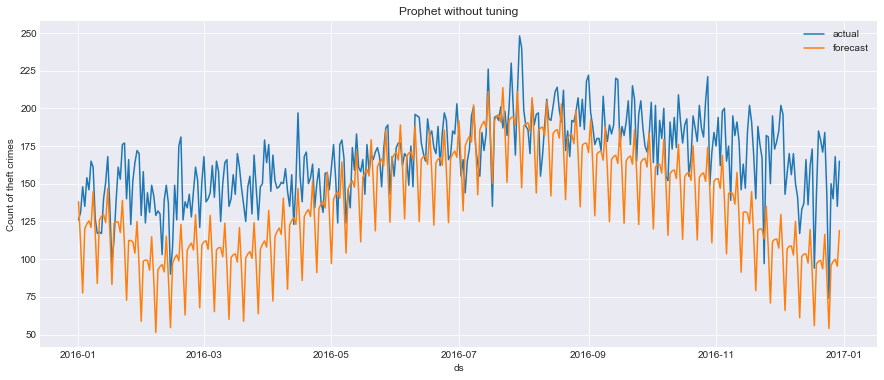

In [785]:
plt.figure(figsize = (15,6))
sns.lineplot(data = result_simple, x = 'ds', y ='y', label = 'actual')
sns.lineplot(data = result_simple, x = 'ds', y ='yhat', label = 'forecast')
plt.title('Prophet without tuning')
plt.ylabel('Count of theft crimes')
plt.legend()
plt.show()

### Tuning the Prophet model

#### Prepare training, test and validation data set

In [725]:
train = df[(df['Primary Type'] == 'THEFT') & (df.year < 2015)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'date':'ds','Date':'y'})

train.head()

,ds,y
0,2001-01-01,672
1,2001-01-02,422
2,2001-01-03,447
3,2001-01-04,480
4,2001-01-05,513


In [726]:
test = df[(df['Primary Type'] == 'THEFT') & (df.year == 2015)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'date':'ds','Date':'y'})

test.head()

,ds,y
0,2015-01-01,151
1,2015-01-02,130
2,2015-01-03,136
3,2015-01-04,108
4,2015-01-05,123


In [727]:
val = df[(df['Primary Type'] == 'THEFT') & (df.year == 2016)].groupby(['date'])['Date'].\
        count().reset_index().rename(columns = {'date':'ds','Date':'y'})

val.head()

,ds,y
0,2016-01-01,126
1,2016-01-02,131
2,2016-01-03,148
3,2016-01-04,135
4,2016-01-05,154


In [728]:
train_log = train.copy()
train_log.y = np.log(train.y)

test_log = test.copy()
test_log.y = np.log(test.y)

#### Set up the model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\shukhrat.khodjaev\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



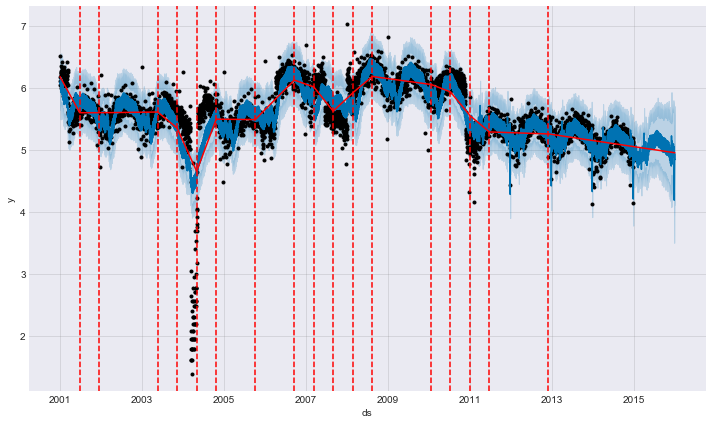

In [729]:
xmas = pd.DataFrame({
  'holiday': 'xmas',
  'ds': pd.to_datetime(['2011-12-25', '2012-12-25', '2013-12-25','2014-12-25','2015-12-25','2016-12-25']),
  'lower_window': -25,
  'upper_window': 6})

april = pd.DataFrame({
  'holiday': 'april',
  'ds': pd.to_datetime(['2011-04-01', '2012-04-01', '2013-04-01','2014-04-01','2015-04-01','2016-04-01']),
  'lower_window': -20,
  'upper_window': 20})

holidays = pd.concat([xmas,april])

model = Prophet(changepoint_prior_scale=0.05, 
                changepoint_range=0.85, 
                holidays = holidays,
               weekly_seasonality = True)


#model.add_country_holidays(country_name='US')

model.fit(train_log)

future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

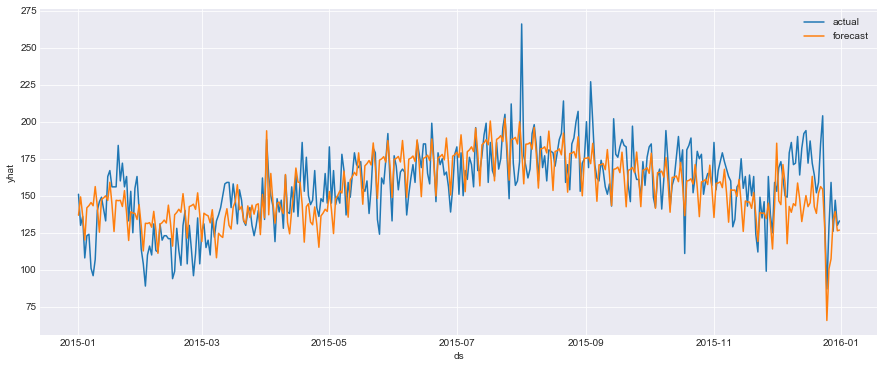

In [731]:
test.ds = pd.to_datetime(test.ds)
result = forecast[forecast.ds > '2014-12-31'][['ds', 'yhat','yhat_upper']]
result = result.merge(test, how ='left', on = 'ds')
result.yhat = np.exp(result.yhat)

plt.figure(figsize = (15,6))
sns.lineplot(data = result, x = 'ds', y ='y', label = 'actual')
sns.lineplot(data = result, x = 'ds', y ='yhat', label = 'forecast')
plt.legend()
plt.show()

In [732]:
print(f'MAPE: {mape(result)}')
print(f'MAPE weighter: {mape_weighted(result)}')
print(f'RMSE: {rmse(result)}')
print(f'MAE: {mae(result)}')

MAPE: 0.10256864278274648
MAPE weighter: 0.09891422281191015
RMSE: 19.72027452453539
MAE: 15.526010009150564


### Validation of tuned Prophet model result

In [736]:
train_test = pd.concat([train, test])
train_test.ds = pd.to_datetime(train_test.ds)
train_test.y = np.log(train_test.y)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\shukhrat.khodjaev\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



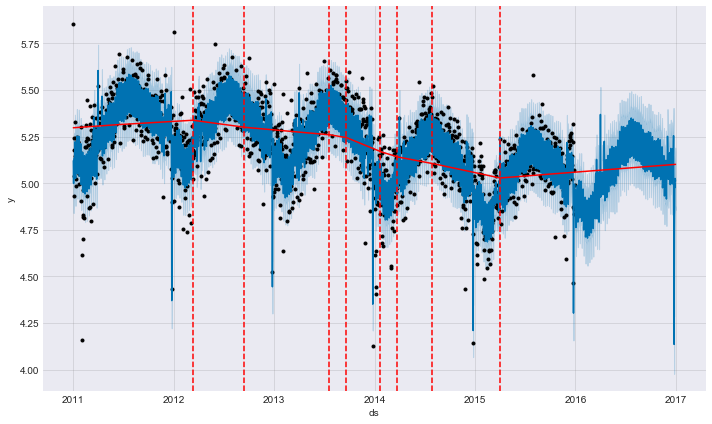

In [737]:
xmas = pd.DataFrame({
  'holiday': 'xmas',
  'ds': pd.to_datetime(['2011-12-25', '2012-12-25', '2013-12-25','2014-12-25','2015-12-25','2016-12-25']),
  'lower_window': -25,
  'upper_window': 6})

april = pd.DataFrame({
  'holiday': 'april',
  'ds': pd.to_datetime(['2011-04-01', '2012-04-01', '2013-04-01','2014-04-01','2015-04-01','2016-04-01']),
  'lower_window': -20,
  'upper_window': 20})

holidays = pd.concat([xmas,april])

model = Prophet(changepoint_prior_scale=0.05, 
                changepoint_range=0.85, 
                holidays = holidays,
               weekly_seasonality = True)


model.fit(train_test[train_test.ds > '2010-12-31'])

future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

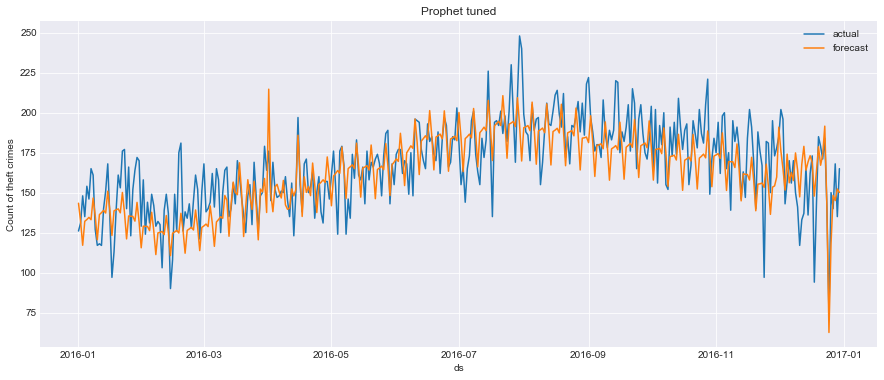

In [738]:
val.ds = pd.to_datetime(val.ds)

result = forecast[forecast.ds > '2015-12-31'][['ds', 'yhat','yhat_upper']]
result = result.merge(val, how ='left', on = 'ds')
result.yhat = np.exp(result.yhat)

plt.figure(figsize = (15,6))
sns.lineplot(data = result, x = 'ds', y ='y', label = 'actual')
sns.lineplot(data = result, x = 'ds', y ='yhat', label = 'forecast')
plt.title('Prophet tuned')
plt.ylabel('Count of theft crimes')
plt.legend()
plt.show()

In [739]:
print(f'MAPE: {mape(result)}')
print(f'MAPE weighted: {mape_weighted(result)}')
print(f'RMSE: {rmse(result)}')
print(f'MAE: {mae(result)}')

MAPE: 0.09337386303437574
MAPE weighted: 0.09084722005727136
RMSE: 19.223698527781686
MAE: 15.187166228642697


In [740]:
fill_fclog(result, fc_type = 'prophet_tuned')

{'mean': [0.1805281284302748,
  0.15642892509582376,
  32.98181488810464,
  26.142863555563604],
 'median': [0.17774259239803647,
  0.15415174849183386,
  32.52670193545319,
  25.762295081967213],
 'mean_doy': [0.1604263715954055,
  0.14562100479016465,
  30.37105682876668,
  24.33661202185793],
 'median_doy': [0.17131859851919923,
  0.15673484068206717,
  32.703210851535665,
  26.193989071038253],
 'prophet_vanila': [0.1994238610993717,
  0.19519581420994792,
  39.5579657635588,
  32.63139230537699],
 'prophet_tuned': [0.09337386303437574,
  0.09084722005727136,
  19.223698527781686,
  15.187166228642697]}

# Comparison of all forecasting approaches

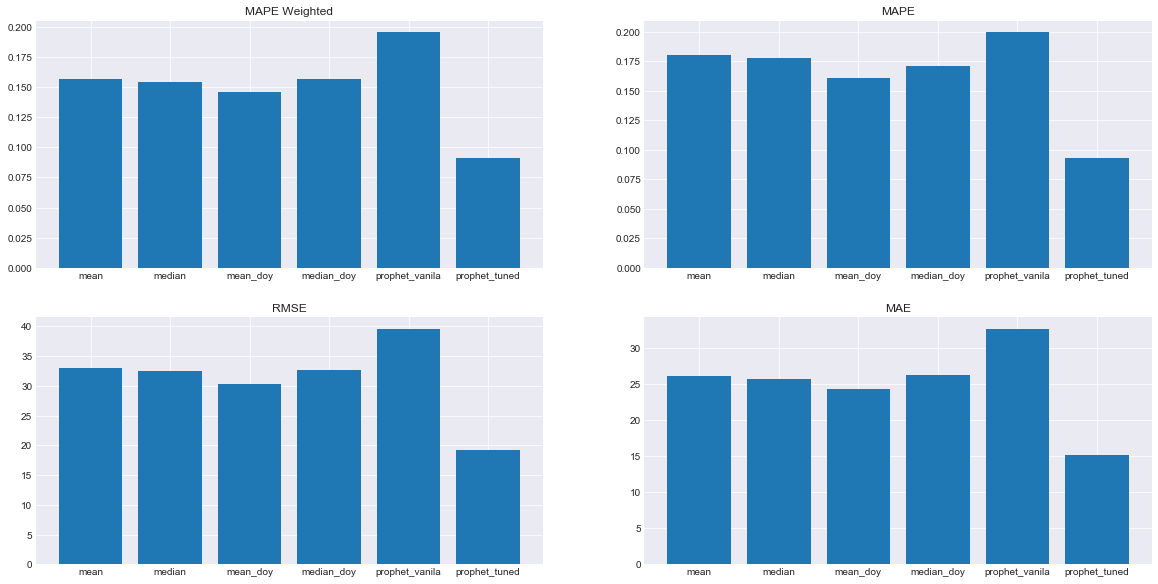

In [674]:
xfc = []
xmape = []
xmapew = []
xrmse = []
xmae = []

for k,v in fclog.items():
    xfc.append(k)
    xmape.append(fclog.get(k)[0])
    xmapew.append(fclog.get(k)[1])
    xrmse.append(fclog.get(k)[2])
    xmae.append(fclog.get(k)[3])



fig, axes = plt.subplots(nrows=2,ncols =2, figsize = (20,10))
axes[0,0].set_title('MAPE Weighted')
axes[0,0].bar(xfc,xmapew)

axes[0,1].set_title('MAPE')
axes[0,1].bar(xfc,xmape)


axes[1,0].set_title('RMSE')
axes[1,0].bar(xfc,xrmse)


axes[1,1].set_title('MAE')
axes[1,1].bar(xfc,xmae)

plt.show()

In [661]:
fc_overview = pd.DataFrame({'FC approach':xfc, 'MAPE':xmape, 'MAPE_weighted':xmapew, 'RMSE':xrmse, 'MAE':xmae})
fc_overview

,FC approach,MAPE,MAPE_weighted,RMSE,MAE
0,mean,0.180528,0.156429,32.981815,26.142864
1,median,0.177743,0.154152,32.526702,25.762295
2,mean_doy,0.160426,0.145621,30.371057,24.336612
3,median_doy,0.171319,0.156735,32.703211,26.193989
4,prophet_vanila,0.199424,0.195196,39.557966,32.631392
5,prophet_tuned,0.093374,0.090847,19.223699,15.187166


# Plot all forecasts

In [767]:
result['mean'] = mean
result['median'] = median
result['dayofyear'] = result.ds.dt.dayofyear
result = result.merge(mean_doy, how ='left', on = 'dayofyear')
result = result.merge(median_doy, how ='left', on = 'dayofyear')
result['prophet-untuned'] = result_simple['yhat']

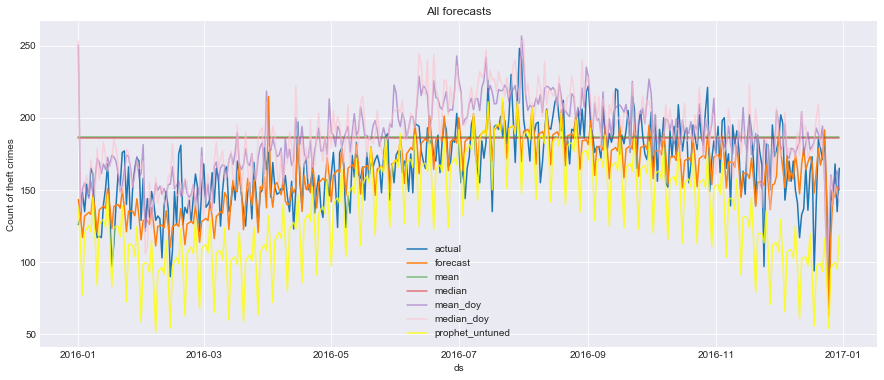

In [791]:
plt.figure(figsize = (15,6))
sns.lineplot(data = result, x = 'ds', y ='y', label = 'actual')
sns.lineplot(data = result, x = 'ds', y ='yhat', label = 'forecast')
sns.lineplot(data = result, x = 'ds', y ='mean', label = 'mean', alpha = 0.6)
sns.lineplot(data = result, x = 'ds', y ='median', label = 'median', alpha = 0.6)
sns.lineplot(data = result, x = 'ds', y ='Count_x', label = 'mean_doy', alpha = 0.6)
sns.lineplot(data = result, x = 'ds', y ='Count_y', label = 'median_doy', color = 'pink', alpha = 0.6)
sns.lineplot(data = result, x = 'ds', y ='prophet-untuned', label = 'prophet_untuned', color = 'yellow', alpha = 0.8)

plt.title('All forecasts')
plt.ylabel('Count of theft crimes')
plt.legend()
plt.show()